# GODAS
https://catalog.pangeo.io/browse/master/ocean/GODAS/

https://www.psl.noaa.gov//data/gridded/data.godas.html

In [15]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [16]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.84980f0837b64446a8b64bfb6bb4d22e Dashboard: /services/dask-gateway/clusters/prod.84980f0837b64446a8b64bfb6bb4d22e/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [79]:
client.close()
cluster.close()

In [17]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline

In [18]:
xr.set_options(display_style='text')

In [19]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
mapping = fs.get_mapper('gs://pangeo-ncep-godas')
ds = xr.open_zarr(mapping, consolidated=True)

In [20]:
ds

<xarray.Dataset>
Dimensions:    (lat: 417, lat_u: 417, level: 40, level_w: 40, lon: 360, lon_u: 360, time: 471)
Coordinates:
  * lat        (lat) float32 -74.17 -73.83 -73.5 -73.17 ... 63.83 64.17 64.5
  * lat_u      (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67
  * level      (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * level_w    (level_w) float32 10.0 20.0 30.0 ... 4.225e+03 4.736e+03
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lon_u      (lon_u) float32 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
Data variables:
    dbss_obil  (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    dbss_obml  (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    dzdt       (time, level_w, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    pottmp     (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    salt       (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    sltfl      (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    sshg       (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    thflx      (time, lat, lon) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    ucur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    uflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
    vcur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 417, 360), meta=np.ndarray>
    vflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 417, 360), meta=np.ndarray>
Attributes:
    Conventions:      COARDS
    References:       https://www.esrl.noaa.gov/psd/data/gridded/data.godas.html
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    grib_file:        godas.M.198001-12.grb
    history:          Created 2006/12 by Hoop
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    title:            GODAS: Global Ocean Data Assimilation System

In [21]:
dt_values = (np.diff(ds.time) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[0:-1])}) #shaves off last time stamp in `ds.time`
ds.coords['dt'] = dt

In [22]:
#Changing longitude coords from 0:360 to -180:180
ds_roll = ds.roll(lon=-180).copy()
ds_roll_drop_lon = ds_roll.drop('lon')
lon = ds_roll.lon.data
lon[lon>180.] -= 360.
ds_roll_drop_lon.coords['lon'] = ('lon', lon)
ds_roll_drop_lon.lon

ds_roll_u = ds_roll_drop_lon.roll(lon_u=-180).copy()
ds_roll_drop_lon_u = ds_roll_u.drop('lon_u')
lon_u = ds_roll_u.lon_u.data
lon_u[lon_u>180.] -= 360.
ds_roll_drop_lon_u.coords['lon_u'] = ('lon_u', lon_u)

<ipython-input-22-faf756f2a2d8>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll = ds.roll(lon=-180).copy()
<ipython-input-22-faf756f2a2d8>:9: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll_u = ds_roll_drop_lon.roll(lon_u=-180).copy()


In [23]:
coords = ds_roll_drop_lon_u.coords.to_dataset().reset_coords()
ds = ds_roll_drop_lon_u.reset_coords(drop=True)

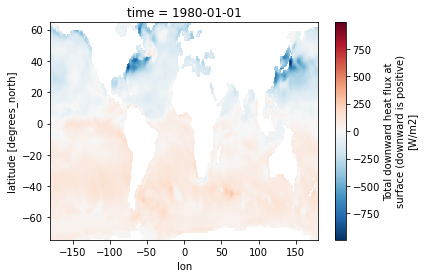

In [10]:
ds.thflx[0].plot()

In [24]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'lon', 'right': 'lon_u'}, 
                             'Y': {'center': 'lat', 'right': 'lat_u'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'level', 'right': 'level_w'}},
                     periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> right
  * right    lon_u --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> right
  * right    lat_u --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   level --> right
  * right    level_w --> center

#### What can we compute with GODAS ds?
- [ ] surf flux
- [ ] in/outflow i.e transport at boundaries
- [ ] residual (consists of diff fluxes, numerical and discretization residuals)
- [ ] total tendency

## <font color='Green'>Get cell area and volume in meters</font>

In [25]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360
meters_per_degree

111194.92664455873

In [26]:
#converting degrees lat to lat [meters]
delta_lat = grid.diff(coords.lat, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree
delta_lat_u = grid.diff(coords.lat_u, 'Y', boundary='fill', fill_value=np.nan)
dy_u = delta_lat_u * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid.diff(coords.lon, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(coords.lat))
delta_lon_u = grid.diff(coords.lon_u, 'X', boundary_discontinuity=360)
dx_u = delta_lon_u * meters_per_degree * np.cos(np.deg2rad(coords.lat_u))

In [27]:
dz = grid.diff(ds.level_w, 'Z', boundary='fill', fill_value=0.)

In [13]:
dy_u.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... 63.5 63.83 64.17 64.5

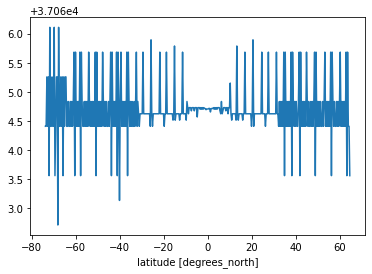

In [14]:
dy_u.plot()

In [53]:
dx.coords

Coordinates:
  * lon_u    (lon_u) float32 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... 63.5 63.83 64.17 64.5

In [52]:
dx_u.coords

Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67

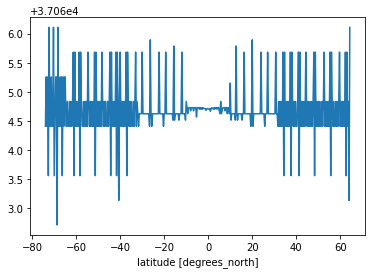

In [74]:
dy.plot()

(64.0, 65.0)

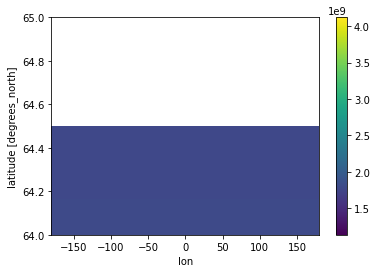

In [97]:
(dx_u * dy).plot(y='lat_u')
plt.ylim(64, 65)

(64.0, 65.0)

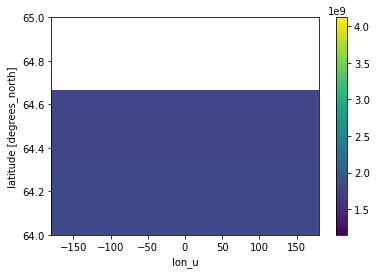

In [96]:
(dx * dy_u).plot(y='lat')
plt.ylim(64, 65)

In [89]:
dx.coords

Coordinates:
  * lon_u    (lon_u) float32 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... 63.5 63.83 64.17 64.5

In [86]:
dx_u.coords

Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67

In [51]:
dy.coords

Coordinates:
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67

In [57]:
ds.vcur.coords

Coordinates:
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lon_u    (lon_u) float32 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0

In [28]:
cell_area = dx * dy_u
cell_volume = dx * dy_u * dz
cell_area_u = dx_u * dy
cell_volume_u = dx_u * dy * dz

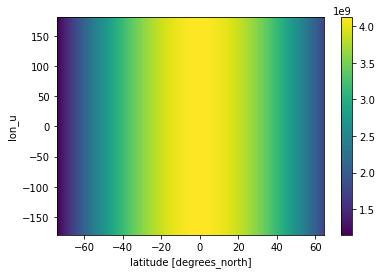

In [17]:
cell_area.plot()

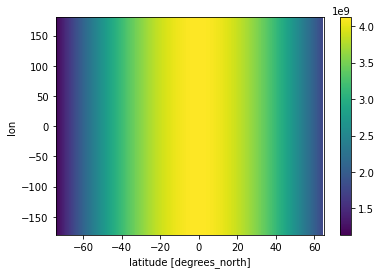

In [18]:
cell_area_u.plot()

## <font color='Green'>\begin{equation*} Set\ to\ WG,\ create\ grid \end{equation*}</font>

In [29]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-74.16667˚S
upper_lat = 37 #-61.83˚S
left_lon =  114 #65.5˚W
right_lon = 210 #30.5˚E

lower_lat_u = 0 #-74.0
upper_lat_u = 37 #-61.67 python is left exclusive so will have -62.0 in array
left_lon_u = 114 #65.0˚W 
right_lon_u = 210 #31.0˚E python is left exclusive so will have 30.0˚E

In [30]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat), lat_u=slice(lower_lat_u, upper_lat_u))
lon_range = dict(lon=slice(left_lon, right_lon), lon_u=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(lat=slice(lower_lat, upper_lat))
lon_range_no_u = dict(lon=slice(left_lon, right_lon))

lat_range_u = dict(lat_u=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(lon_u=slice(left_lon_u, right_lon_u))

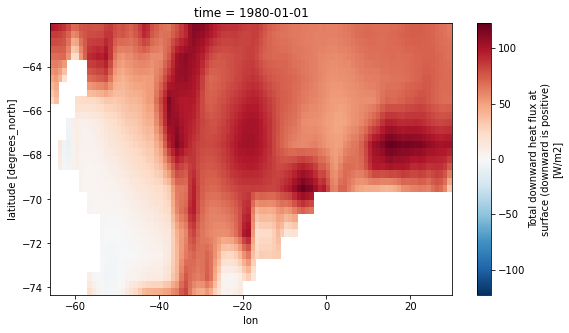

In [31]:
ds.thflx[0].isel(**lat_range_no_u, **lon_range_no_u).plot(figsize=(9,5))

In [32]:
ds_wg = ds.isel(**lat_range, **lon_range)
coords_wg = coords.isel(**lat_range, **lon_range)

cell_area_wg = cell_area.isel(**lat_range_no_u, **lon_range_u)
cell_volume_wg = cell_volume.isel(**lat_range_no_u, **lon_range_u)

cell_area_u_wg = cell_area_u.isel(**lat_range_u, **lon_range_no_u)
cell_volume_u_wg = cell_volume_u.isel(**lat_range_u, **lon_range_no_u)

In [34]:
dz

<xarray.DataArray (level: 40)>
array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        11.,  19.,  32.,  52.,  78., 109., 144., 183., 223., 265., 307.,
       347., 386., 421., 452., 478., 498., 511.], dtype=float32)
Coordinates:
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03

In [37]:
dx_wg = dx.isel(**lon_range_u, **lat_range_no_u)
dx_u_wg = dx_u.isel(**lon_range_no_u, **lat_range_u)

dy_wg = dy.isel(**lat_range_u)
dy_u_wg = dy_u.isel(**lat_range_no_u)

In [38]:
grid_wg = xgcm.Grid(ds_wg, coords={'X': {'center': 'lon', 'right': 'lon_u'}, 
                                   'Y': {'center': 'lat', 'right': 'lat_u'},
                                   'T': {'center': 'time'},
                                   'Z': {'center': 'level', 'right': 'level_w'}},
                     periodic=['X'])
grid_wg

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> right
  * right    lon_u --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> right
  * right    lat_u --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   level --> right
  * right    level_w --> center

1. interpolate temp onto psi_vel terms
2. rhs = surf + vel
3. lhs = total_tend
4. lhs = rhs

In [39]:
temp = ds_wg.pottmp - 273.15 #K to C
salt = ds_wg.salt * 1000 #kg/kg to g/kg

## <font color='Green'>\begin{equation*} Surface\ Fluxes \end{equation*}</font>

In [41]:
ds_wg.thflx

<xarray.DataArray 'thflx' (time: 471, lat: 37, lon: 96)>
dask.array<getitem, shape=(471, 37, 96), dtype=float32, chunksize=(12, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
Attributes:
    center:                   US National Weather Service - NCEP (WMC)
    dataset:                  NCEP GODAS
    gds_grid_type:            0
    level_desc:               surface
    level_indicator:          1
    long_name:                Total downward heat flux at surface (downward i...
    parameter_number:         202
    parameter_table_version:  129
    parent_stat:              Individual Obs
    statistic:                Monthly Mean
    sub_center:               Environmental Modeling Center
    units:                    W/m2
    unpacked_valid_range:     [-1400.0, 1400.0]
    valid_range:              [-16384, 16384]
    var_desc:                 total downward heat flux at surface

In [47]:
dx

<xarray.DataArray (lon_u: 360, lat: 417)>
array([[30338.424, 30960.258, 31581.055, ..., 49036.895, 48455.49 ,
        47872.406],
       [30338.424, 30960.258, 31581.055, ..., 49036.895, 48455.49 ,
        47872.406],
       [30338.424, 30960.258, 31581.055, ..., 49036.895, 48455.49 ,
        47872.406],
       ...,
       [30338.424, 30960.258, 31581.055, ..., 49036.895, 48455.49 ,
        47872.406],
       [30338.424, 30960.258, 31581.055, ..., 49036.895, 48455.49 ,
        47872.406],
       [30338.424, 30960.258, 31581.055, ..., 49036.895, 48455.49 ,
        47872.406]], dtype=float32)
Coordinates:
  * lon_u    (lon_u) float32 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... 63.5 63.83 64.17 64.5

In [43]:
ds_wg.thflx

<xarray.DataArray 'thflx' (time: 471, lat: 37, lon: 96)>
dask.array<getitem, shape=(471, 37, 96), dtype=float32, chunksize=(12, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
Attributes:
    center:                   US National Weather Service - NCEP (WMC)
    dataset:                  NCEP GODAS
    gds_grid_type:            0
    level_desc:               surface
    level_indicator:          1
    long_name:                Total downward heat flux at surface (downward i...
    parameter_number:         202
    parameter_table_version:  129
    parent_stat:              Individual Obs
    statistic:                Monthly Mean
    sub_center:               Environmental Modeling Center
    units:                    W/m2
    unpacked_valid_range:     [-1400.0, 1400.0]
    valid_range:              [-16384, 16384]
    var_desc:                 total downward heat flux at surface

In [40]:
thflx_interp = grid_wg.interp(ds_wg.thflx, ['X', 'Y'], boundary='fill')
slt_flux_interp = grid_wg.interp(ds_wg.sltfl, ['X', 'Y'], boundary='fill')

In [41]:
thflx_interp.lon_u

<xarray.DataArray 'lon_u' (lon_u: 96)>
array([-65., -64., -63., -62., -61., -60., -59., -58., -57., -56., -55., -54.,
       -53., -52., -51., -50., -49., -48., -47., -46., -45., -44., -43., -42.,
       -41., -40., -39., -38., -37., -36., -35., -34., -33., -32., -31., -30.,
       -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19., -18.,
       -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,
        -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.],
      dtype=float32)
Coordinates:
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [42]:
dx_wg.lon_u

<xarray.DataArray 'lon_u' (lon_u: 96)>
array([-65., -64., -63., -62., -61., -60., -59., -58., -57., -56., -55., -54.,
       -53., -52., -51., -50., -49., -48., -47., -46., -45., -44., -43., -42.,
       -41., -40., -39., -38., -37., -36., -35., -34., -33., -32., -31., -30.,
       -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19., -18.,
       -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,
        -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.],
      dtype=float32)
Coordinates:
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [64]:
dy.coords

Coordinates:
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67

In [61]:
dx_wg.coords

Coordinates:
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17

In [62]:
dx_u_wg.coords

Coordinates:
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0

In [53]:
dx_wg_interp = grid_wg.interp(dx_wg, ['Y'], boundary='fill')

In [32]:
thflx_interp.coords

Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [33]:
dx_wg_interp.coords

Coordinates:
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0

In [37]:
heat_capacity_cp = 3.994e3 #J/kg/˚C
runit2mass = 1.035e3 #rho

surf_flux_th = (thflx_interp * dy_wg * dx_wg_interp) / (heat_capacity_cp * runit2mass) #˚C*m^3/s
surf_flux_slt = (slt_flux_interp * dy_wg * dx_wg_interp * 1e4) / runit2mass # psu*m^3/s

In [38]:
surf_flux_th

<xarray.DataArray (time: 471, lat_u: 37, lon_u: 96)>
dask.array<truediv, shape=(471, 37, 96), dtype=float32, chunksize=(12, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [39]:
surf_flux_slt

<xarray.DataArray (time: 471, lat_u: 37, lon_u: 96)>
dask.array<truediv, shape=(471, 37, 96), dtype=float32, chunksize=(12, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [76]:
ds_wg.thflx[0]

<xarray.DataArray 'thflx' (lat: 37, lon: 96)>
dask.array<getitem, shape=(37, 96), dtype=float32, chunksize=(37, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
    time     datetime64[ns] 1980-01-01
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
Attributes:
    center:                   US National Weather Service - NCEP (WMC)
    dataset:                  NCEP GODAS
    gds_grid_type:            0
    level_desc:               surface
    level_indicator:          1
    long_name:                Total downward heat flux at surface (downward i...
    parameter_number:         202
    parameter_table_version:  129
    parent_stat:              Individual Obs
    statistic:                Monthly Mean
    sub_center:               Environmental Modeling Center
    units:                    W/m2
    unpacked_valid_range:     [-1400.0, 1400.0]
    valid_range:              [-16384, 16384]
    var_desc:                 total downward heat flux at surface

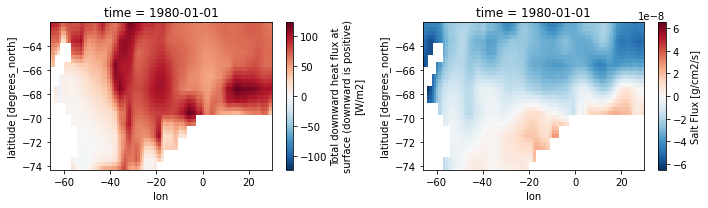

In [80]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
ds_wg.thflx[0].plot(ax=ax0)
ds_wg.sltfl[0].plot(ax=ax1)
plt.tight_layout();

In [36]:
surf_flux_slt

<xarray.DataArray (time: 471, lat: 36, lon: 95, lon_u: 96)>
dask.array<truediv, shape=(471, 36, 95, 96), dtype=float32, chunksize=(12, 36, 95, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [37]:
surf_flux_th

<xarray.DataArray (time: 471, lat: 36, lon: 95, lon_u: 96)>
dask.array<truediv, shape=(471, 36, 95, 96), dtype=float32, chunksize=(12, 36, 95, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [82]:
surf_flux_slt

<xarray.DataArray (time: 471, lat: 37, lon: 96, lat_u: 417, lon_u: 96)>
dask.array<truediv, shape=(471, 37, 96, 417, 96), dtype=float32, chunksize=(12, 37, 96, 417, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... 64.0 64.33 64.67
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

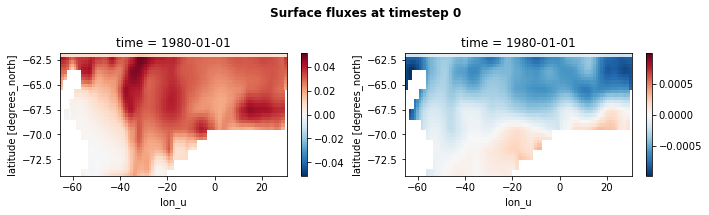

In [40]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th[0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt[0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Surface fluxes at timestep 0', fontweight='bold')
plt.tight_layout();

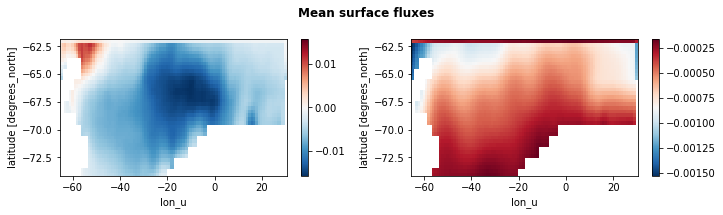

In [41]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(surf_flux_th/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(surf_flux_slt/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.suptitle('Mean surface fluxes', fontweight='bold')
plt.tight_layout();

In [48]:
def surface_to_3d(da):
    da = da.copy()
    da.coords['level'] = ds_wg.level[0]
    da = da.expand_dims(dim='level', axis=1)
    da, _ = xr.align(da, coords.level, join='right')
    return da.fillna(0.)

In [49]:
surf_flux_th

<xarray.DataArray (time: 471, lat_u: 37, lon_u: 96)>
dask.array<truediv, shape=(471, 37, 96), dtype=float32, chunksize=(12, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [50]:
surf_flux_conv_TH = surface_to_3d(surf_flux_th)
surf_flux_conv_SLT = surface_to_3d(surf_flux_slt)

## <font color='Green'>\begin{equation*} \Psi_{vel}\ at\ boundary\end{equation*}</font>

In [46]:
u_transport_right = (ds_wg.ucur[:, 1:, 1:, 1:] * dy_u.isel(**lat_range_u)[:-1] * dz).isel(lon_u=-1)
u_transport_left = (ds_wg.ucur[:, 1:, 1:, 1:] * dy_u.isel(**lat_range_u)[:-1] * dz).isel(lon_u=0)

v_transport = (ds_wg.vcur[:, 1:, 1:, 1:] * dx_u.isel(**lon_range_u, **lat_range_u)[:-1, :-1] * dz).isel(lat_u=-1)
#units: m^3/s

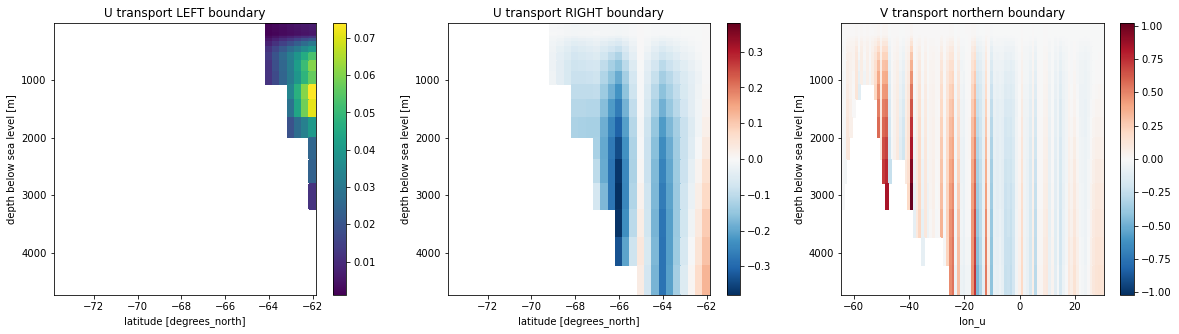

In [47]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [48]:
u_transport_mean_value = (u_transport_right.sum(dim=['lat_u', 'level']) -
                          u_transport_left.sum(dim=['lat_u', 'level'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-46.109703, dtype=float32)

In [49]:
v_transport_mean_value = (v_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(46.369274, dtype=float32)
Coordinates:
    lat_u    float32 -62.0

In [50]:
residual = u_transport_mean_value + v_transport_mean_value
residual

<xarray.DataArray ()>
array(0.25957108, dtype=float32)
Coordinates:
    lat_u    float32 -62.0

## <font color='Green'>\begin{equation*} \vec{\textbf{u}} \cdot \nabla \theta \end{equation*}</font>

## Compute conv_horiz_adv_flux

If you want to go down this road
1. Check divergence see if it's 0 -> $\nabla \textbf{u}$
2. If it is then continue to construct something similar to $\Psi_{adv}$
3. This can help make residual due to diffusion more accurate since you'll have $\Psi_{adv}$ =  $\Psi_{vel}$ + R2, and R2 will be a known residual not due to diffusion, as well as R1.

In [70]:
ucur_interp = grid.interp(ds_wg.ucur, axis=['X', 'Y'], boundary='fill', keep_coords=True)
vcur_interp = grid.interp(ds_wg.vcur, axis=['X', 'Y'], boundary='fill', keep_coords=True)

In [167]:
temp_interp_x = grid.interp(temp, 'X')
temp_interp_y = grid.interp(temp, 'Y', boundary='fill')

salt_interp_x = grid.interp(salt, 'X')
salt_interp_y = grid.interp(salt, 'Y', boundary='fill')

In [168]:
conv_horiz_adv_flux_TH = - ((ucur_interp * grid.diff(temp_interp_x, 'X')) + (vcur_interp * grid.diff(temp_interp_y, 'Y', boundary='fill')))
conv_horiz_adv_flux_SLT = - ((ucur_interp * grid.diff(salt_interp_x, 'X')) + (vcur_interp * grid.diff(salt_interp_y, 'Y', boundary='fill')))

In [170]:
conv_horiz_adv_flux_TH = conv_horiz_adv_flux_TH[:,:, 1:, 1:] * cell_area_wg[:-1, :-1] #[˚Cm^3/s]
conv_horiz_adv_flux_SLT = conv_horiz_adv_flux_SLT[:,:, 1:, 1:] * cell_area_wg[:-1, :-1] #[˚Cm^3/s]

In [217]:
conv_horiz_adv_flux_TH

<xarray.DataArray (time: 471, level: 40, lat: 36, lon: 95)>
dask.array<mul, shape=(471, 40, 36, 95), dtype=float32, chunksize=(4, 40, 35, 94), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

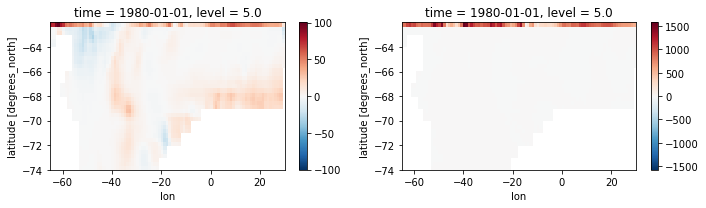

In [171]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(conv_horiz_adv_flux_TH[0,0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(conv_horiz_adv_flux_SLT[0,0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

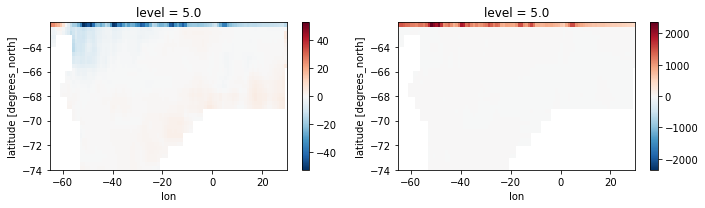

In [175]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(conv_horiz_adv_flux_TH.isel(time=slice(0,-2), level=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(conv_horiz_adv_flux_SLT.isel(time=slice(0,-2), level=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

## <font color='Green'>\begin{equation*} Total\ Tendency \end{equation*}</font>

**Theta Tendency Term**

In [43]:
delta_theta = temp.diff('time')

In [44]:
#forcing delta_theta to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','level','lat','lon'], 
                            coords={'time': coords_wg.dt[0:-1].time.data,
                                    'level': coords_wg.level,
                                    'lat': coords_wg.lat,
                                    'lon': coords_wg.lon})
delta_theta

<xarray.DataArray 'sub-de3395a612aa25bcb58d9466a62fd9d8' (time: 470, level: 40, lat: 37, lon: 96)>
dask.array<sub, shape=(470, 40, 37, 96), dtype=float32, chunksize=(3, 40, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5

In [45]:
coords.dt.time[0:-1]

<xarray.DataArray 'time' (time: 470)>
array(['1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '1980-03-01T00:00:00.000000000', ..., '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [46]:
theta_tend = (delta_theta / coords.dt[0:-1])

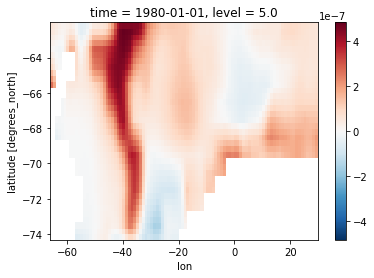

In [144]:
theta_tend[0,0].plot()

In [62]:
theta_tend.coords#[:,1:,1:,1:]

Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5

In [56]:
dx_u_wg_interp = grid_wg.interp(dx_u_wg, ['Y'], boundary='fill')

In [58]:
dx_u_wg_interp.coords

Coordinates:
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17

In [65]:
dy_u_wg.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17

In [61]:
dz.coords

Coordinates:
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03

In [66]:
totttend = theta_tend * dx_u_wg_interp * dy_u_wg * dz

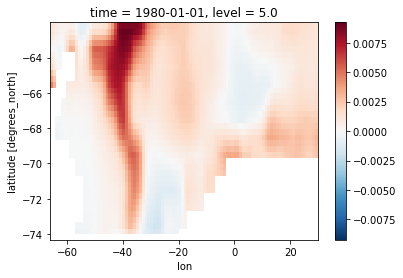

In [67]:
(totttend[0,0]/1e6).plot()

**Salt Tendency Term**

In [68]:
delta_salt = salt.diff('time')

In [69]:
#forcing delta_salt to have same timestamp as ds.dt by creating new data array called "salt_scaled"
delta_salt = xr.DataArray(delta_salt.data, dims=['time','level','lat','lon'], 
                            coords={'time': coords_wg.dt[0:-1].time.data,
                                    'level': coords_wg.level,
                                    'lat': coords_wg.lat,
                                    'lon': coords_wg.lon})
delta_salt

<xarray.DataArray 'sub-fe1bd771cbec7d6cde73c9948878122f' (time: 470, level: 40, lat: 37, lon: 96)>
dask.array<sub, shape=(470, 40, 37, 96), dtype=float32, chunksize=(3, 40, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5

In [70]:
salt_tend = (delta_salt / coords.dt[0:-1])

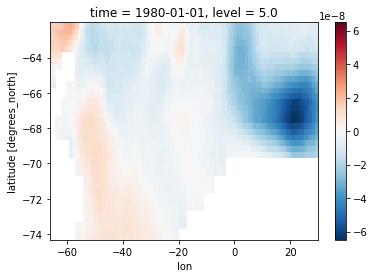

In [71]:
salt_tend[0,0].plot()

In [72]:
salt_tend.coords

Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5

In [73]:
totstend = salt_tend * dx_u_wg_interp * dy_u_wg * dz

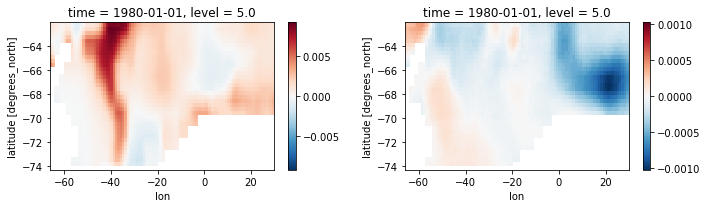

In [75]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax0)
(totstend[0,0]/1e6).plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

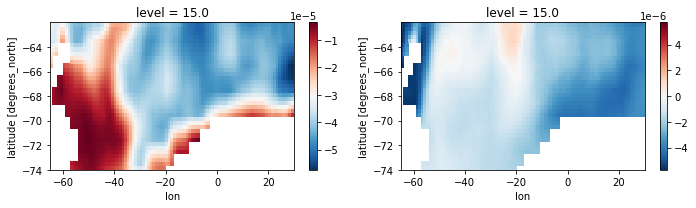

In [165]:
fix, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
(totttend.isel(time=slice(0,-1), level=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax0)
(totstend.isel(time=slice(0,-1), level=0)/1e6).mean(dim='time').plot(cmap='RdBu_r', ax=ax1)
plt.tight_layout();

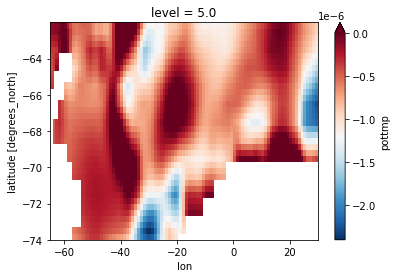

In [115]:
((temp[-3,0, 1:, 1:] - temp[0,0, 1:, 1:])/1e6).plot(cmap='RdBu_r', vmax=0)#, vmin=-6e-5)

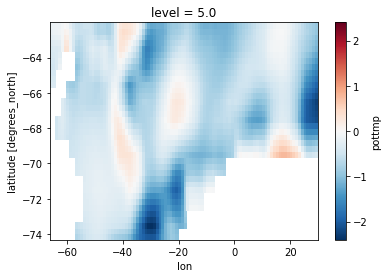

In [116]:
(temp[-3, 0] - temp[0, 0]).plot()

## Budget

In [176]:
rhs = conv_horiz_adv_flux_TH + surf_flux_conv_TH
lhs = totttend
residual = lhs[:-1] - rhs[:-2, 1:]

In [191]:
rhs[:-2, 1:]

<xarray.DataArray (time: 469, level: 39, lat: 36, lon: 95)>
dask.array<getitem, shape=(469, 39, 36, 95), dtype=float32, chunksize=(4, 39, 35, 94), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-01-01
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

In [180]:
lhs[:-1]

<xarray.DataArray (time: 469, level: 39, lat: 36, lon: 95)>
dask.array<getitem, shape=(469, 39, 36, 95), dtype=float32, chunksize=(3, 39, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-01-01
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

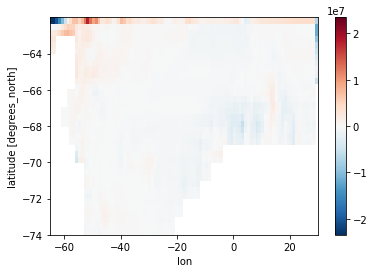

In [193]:
residual.mean(dim=['time', 'level']).plot()

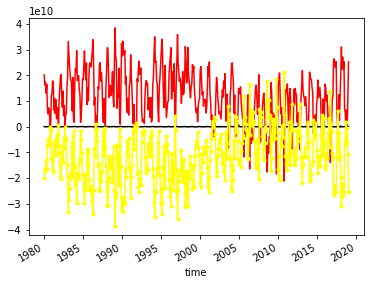

In [214]:
plt.figure()
lhs[:-1].sum(dim=['lat', 'lon', 'level']).plot(color='k')
rhs[:-2, 1:].sum(dim=['lat', 'lon', 'level']).plot(color='red')
residual.sum(dim=['lat', 'lon', 'level']).plot(marker='.', color='yellow')

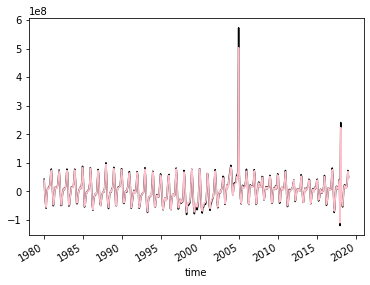

In [215]:
plt.figure()
lhs[:-1].sum(dim=['lat', 'lon', 'level']).plot(color='k')
(residual + rhs[:-2, 1:]).sum(dim=['lat', 'lon', 'level']).plot(color='pink')

In [195]:
rhs[:-2, 1:].shape

(469, 39, 36, 95)

In [196]:
lhs[:-1].shape

(469, 39, 36, 95)

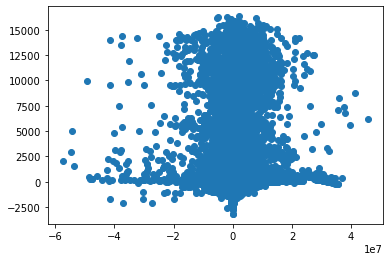

In [197]:
plt.scatter(rhs[:-2, 1:].isel(time=35).values.ravel(), lhs[:-1].isel(time=35).values.ravel())

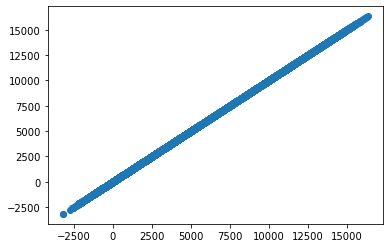

In [216]:
plt.scatter((residual+rhs[:-2, 1:]).isel(time=35).values.ravel(), lhs[:-1].isel(time=35).values.ravel())

In [199]:
check_rhs = sum(rhs)
check_lhs = sum(lhs)
check_residual = sum(residual)

In [212]:
check_rhs + check_residual

<xarray.DataArray (level: 39, lat: 36, lon: 95)>
dask.array<add, shape=(39, 36, 95), dtype=float32, chunksize=(39, 35, 94), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float64 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

In [204]:
check_lhs

<xarray.DataArray (level: 39, lat: 36, lon: 95)>
dask.array<add, shape=(39, 36, 95), dtype=float32, chunksize=(39, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

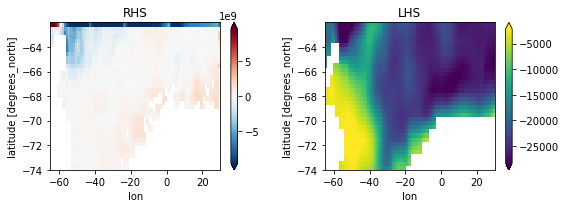

In [207]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
check_rhs[0].drop('time').plot(ax=ax0, robust=True)#, vmax=4e3)
ax0.set_title('RHS')

check_lhs[0].plot(ax=ax1, robust=True)#, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

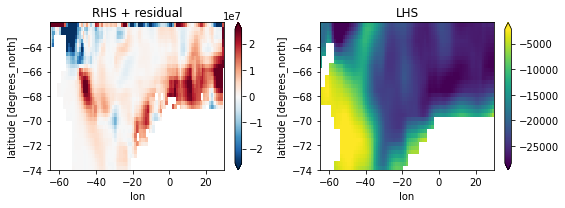

In [213]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
(check_rhs + check_residual)[0].plot(ax=ax0, robust=True)#, vmax=4e3)
ax0.set_title('RHS + residual')

check_lhs[0].plot(ax=ax1, robust=True)#, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

## Saving Data

In [51]:
cell_coords_wg = xr.merge([cell_area_wg.rename('cell_area_wg'),
                       cell_area_u_wg.rename('cell_area_u_wg'),
                       cell_volume_wg.rename('cell_volume_wg'),
                       cell_volume_u_wg.rename('cell_volume_u_wg')])

In [52]:
surf_flux = xr.merge([surf_flux_th.rename('surf_flux_th'), surf_flux_slt.rename('surf_flux_slt')])

In [ ]:
vel = xr.merge([u_transport_right.rename('u_transport_right'),
               u_transport_left.rename('u_transport_left'),
               v_transport.rename('v_transport')])

In [76]:
total_tendency = xr.merge([totttend.chunk({'time':-1}).rename('totttend'),
                           totstend.chunk({'time':-1}).rename('totstend')])

In [53]:
cell_elements_wg = xr.merge([dx_wg.rename('dx'), dx_u_wg.rename('dx_u'), 
                             dy_wg.rename('dy'), dy_u_wg.rename('dy_u'),
                             dx_u_wg_interp.rename('dx_u_interp'),
                             dz.rename('dz')])

In [54]:
cell_elements_wg

<xarray.Dataset>
Dimensions:  (lat: 37, lat_u: 37, level: 40, lon: 96, lon_u: 96)
Coordinates:
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
Data variables:
    dx       (lon_u, lat) float32 3.034e+04 3.096e+04 ... 5.134e+04 5.192e+04
    dx_u     (lon, lat_u) float32 3.065e+04 3.127e+04 ... 5.163e+04 5.22e+04
    dy       (lat_u) float32 3.706e+04 3.707e+04 ... 3.706e+04 3.706e+04
    dy_u     (lat) float32 nan 3.706e+04 3.706e+04 ... 3.706e+04 3.706e+04
    dz       (level) float32 10.0 10.0 10.0 10.0 ... 452.0 478.0 498.0 511.0

In [55]:
surf_flux_conv = xr.merge([surf_flux_conv_TH.rename('surf_flux_conv_TH'),
                           surf_flux_conv_SLT.rename('surf_flux_conv_SLT')])

In [77]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [ ]:
#saving ds_wg
gcsmap_ds_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/ds_wg.zarr')
ds_wg.to_zarr(gcsmap_ds_wg, mode='w')

In [ ]:
#saving coords_wg
gcsmap_coords_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/coords_wg.zarr')
coords_wg.to_zarr(gcsmap_coords_wg, mode='w')

In [57]:
# saving cell_area/cell_volume
gcsmap_cell_coords_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/cell_coords_wg.zarr')
cell_coords_wg.to_zarr(gcsmap_cell_coords_wg, mode='w')

In [58]:
# saving cell_elements
gcsmap_cell_elements = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/cell_elements_wg.zarr')
cell_elements_wg.to_zarr(gcsmap_cell_elements, mode='w')

In [59]:
# saving surface fluxes
gcsmap_surf_flux = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/surf_flux.zarr')
surf_flux.to_zarr(gcsmap_surf_flux, mode='w')

In [60]:
# saving surface fluxes
gcsmap_surf_flux_conv = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/surf_flux_conv.zarr')
surf_flux_conv.to_zarr(gcsmap_surf_flux_conv, mode='w')

In [ ]:
#saving transport terms
gcsmap_vel = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/vel.zarr')
vel.to_zarr(gcsmap_vel, mode='w')

In [78]:
#saving total tendency terms
gcsmap_total_tend = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GODAS/datasets/total_tend.zarr')
total_tendency.to_zarr(gcsmap_total_tend, mode='w')